In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/makemore-utils-nbs')
from utils import create_dataset, CharDataset, evaluate_loss, print_samples
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Read file and create training and test sets
names, vocab, max_length = create_dataset('../names.txt')
# print(len(names), vocab, max_length)
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) # check that dataset is shuffled
train_data = CharDataset(names[:n1], vocab=vocab, max_length=max_length)
test_data = CharDataset(names[n1:], vocab=vocab, max_length=max_length)


In [4]:
class Bigram(nn.Module):
    def __init__(self,vocab_size):
        super(Bigram, self).__init__()
        self.bigram_embedding = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, targets = None):
        logits = self.bigram_embedding(x) # Outputs Batch, Time, Channel (Vocab Size) 
        if targets == None:
            loss = None
        else:
            self.B,self.T,self.C = logits.shape
            logits = logits.view(self.B*self.T,self.C)
            targets = targets.contiguous().view(self.B*self.T)
            loss = F.cross_entropy(logits, targets, ignore_index=-1)
            
        return logits, loss

## Notes on model architecture

Model has only 1 layer - the embedding layer. These always seems a little magical to me to lets try to understand what it means physically - we will validate this quantitatively as well. The layer is a matrix of vocab_size x vocab_size where vocab_size = 27 (alphabets + stop character). I think of this in 2 ways:

1. Less generic - the rows and columns indices of matrix are vocab elements and the matrix cells are the probability that the vocab element indexing the row appears after the vocab element indexing the column. Its basically trying to captured the conditional probability that row element appears given that the column element just appeared
2. More generic - ^^ physical interpretation works for this case but more generally we will choose embeddings to have arbitrary vector dimensions which dont have vocab size in one of the dimensions. In this case you can think of each vocab element repesented by an n dimensional vector where each dimension does not need to mean anything specific we can associate with our physical world. (I mean you can always torture a mapping if you want to ...). These vectors then get dotted and operated up by appropriate NN operators to finallly provide the probability of x (where x can be vector respresenting some combination of words) -> results in vocab element y.
3. By quantifying we mean we can do 2 things - in this case we can plot the cross correlation matrix between the 2 vocab sizes to see elements likelihood of preceding one another. In more general case (also in this?) we can plot the embeddings in 2 dimensions using PCA or TSNE to see which elements group together and whether that makes sense e.g. I would expect vowels to be close, less common alphabets to be separated out etc.

In [5]:
# Set up optimizer
vocab_size = len(vocab) + 1 # +1 for special characters
model = Bigram(vocab_size)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [6]:
# Training loop - update to evaluate loss on ongoing basis and printing results, understand whats going on in the bigram model - ie why isnt it working with embedding 
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

tr_loss = []
te_loss = []

for steps in range(5000):
    xb, yb = next(iter(train_dataloader))
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    ltr, lte = evaluate_loss(model, train_dataloader, test_dataloader, num_batches=10)
    tr_loss.append(ltr)
    te_loss.append(lte)
    # print(loss.item())

    # if steps % 99 == 0:
    #     print('ltr: ', ltr, 'lte: ', lte, 'single shot loss:', loss.item())

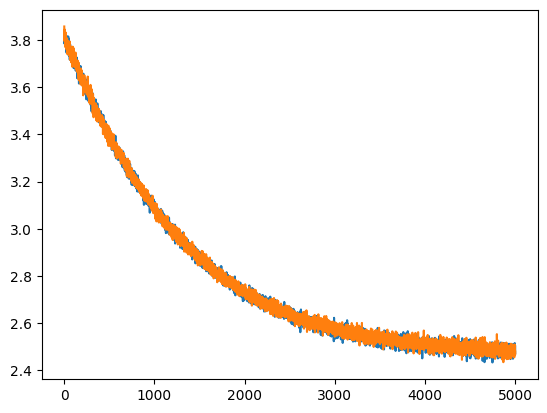

In [8]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss)
plt.plot(te_loss)

plt.show()

In [9]:
## Pretty print the samples
print_samples(model, train_data, max_length, num=10)

jie
catwbrdaurumori
awn
fa
salere
mcperinytigaena
hai
be
cowielamdetriwe
n


In [10]:
ticklabels = list(train_data.itos.values())
ticklabels.insert(0,'stop')
x_ticklabel_vec = np.arange(len(ticklabels))
y_ticklabel_vec = np.arange(len(ticklabels))
print(ticklabels)

['stop', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


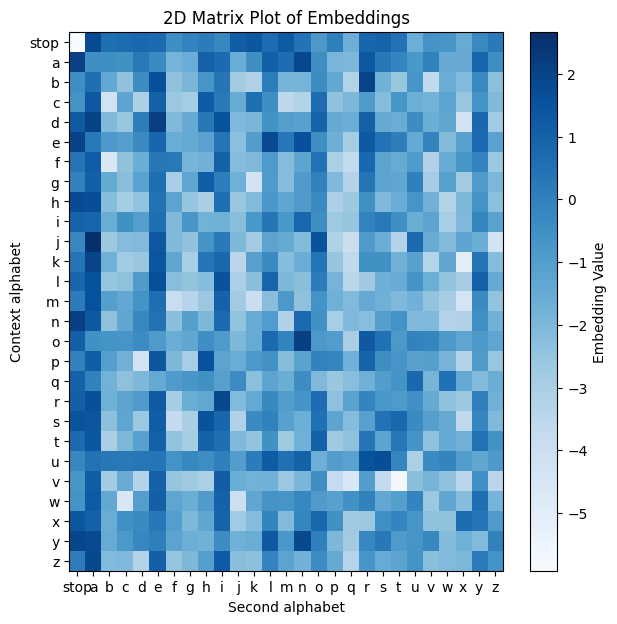

In [11]:
## Plot the cross correlation matrix for the embeddings - note that its asymmetric
# model.bigram_embedding.weight.shape
embeddings_matrix = model.bigram_embedding.weight.data.cpu().numpy()

# Plot the embedding matrix as a 2D matrix plot
plt.figure(figsize=(7,7))
plt.imshow(embeddings_matrix, cmap='Blues', aspect='auto')
plt.colorbar(label='Embedding Value')
plt.title('2D Matrix Plot of Embeddings')
plt.xlabel('Second alphabet')
plt.ylabel('Context alphabet')
plt.xticks(x_ticklabel_vec, ticklabels)
plt.yticks(y_ticklabel_vec, ticklabels)
plt.show()

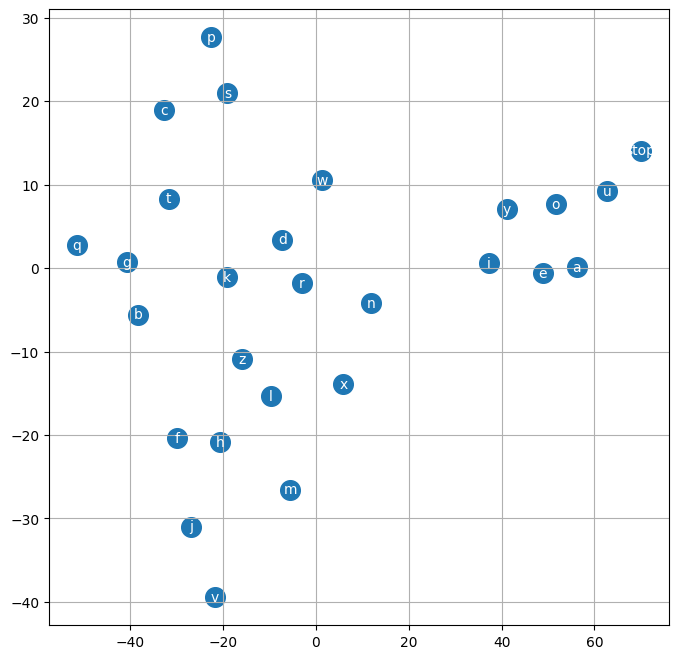

In [15]:
## Plot tsne or pca for embeddings
from sklearn.manifold import TSNE

# t-SNE example:
tsne = TSNE(n_components=2, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings_matrix)

# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embeddings_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), ticklabels[i], ha="center", va="center", color='white')
plt.grid('minor')

## Observations
### Subjective appraisal
1. Not great names being printed - though some are in the realm of reasonable
### Embeddings matrix
1. Stop by design does not come before any character. Stop comes after all characters
2. Vowels all come after various consonants
3. 'u' has high likelihood of following 'q'
### TSNE
1. Vowels do get separated
2. 'Stop' gets clustered with vowels